**Research Question 1 (Regression):** Can we accurately predict a driver's fastest lap time using only *pre-race* data?
- **Methods:** Ridge Regression and LASSO (to handle multicollinearity).
- **Goal:** Identify the most critical pre-race factors (e.g., qualifying performance, grid position) while avoiding "data leakage" (using post-race data like average lap time).

Import and Loading of the Data

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

filepath = glob.glob('f1datasets/*.csv') # 14 datasets
f1_dfs = {}
for file in filepath:
    filename = os.path.basename(file)
    df_name = os.path.splitext(filename)[0]
    f1_dfs[df_name] = pd.read_csv(file)
print("Datasets loaded.")

rand_st = 7604 # random state for reproducibility

cv5 = KFold(n_splits=5, shuffle=True, random_state=rand_st) # 5-fold cross-validation

Datasets loaded.


**Cleaning the data // Feature Engineering (driver_age_at_race)**

In [66]:
for df_name in f1_dfs:
    f1_dfs[df_name].replace(r'\\N', np.nan, inplace=True)
print("Missing values replaced.")

def time_to_ms(time_str): # converts time strings to milliseconds
    if pd.isna(time_str): 
        return np.nan
    parts = str(time_str).split(':')
    try: 
        if len(parts) == 2: # M:SS.mmm
            return int((int(parts[0]) * 60 + float(parts[1])) * 1000)
        elif len(parts) == 3: # H:MM:SS.mmm
            return int((int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])) * 1000)
        else: return np.nan
    except ValueError: 
        return np.nan

# Clean 'results' (Response Variables)
df_results = f1_dfs['results'].copy()
df_results['fastestLapTime_ms'] = df_results['fastestLapTime'].apply(time_to_ms)
df_results['positionOrder'] = pd.to_numeric(df_results['positionOrder'], errors='coerce')
df_results['grid'] = pd.to_numeric(df_results['grid'], errors='coerce')

# Clean 'qualifying' (Predictors)
df_quali = f1_dfs['qualifying'].copy()
for col in ['q1', 'q2', 'q3']:
    df_quali[f'{col}_ms'] = df_quali[col].apply(time_to_ms)
df_quali_short = df_quali[['raceId', 'driverId', 'constructorId', 'position', 'q1_ms', 'q2_ms', 'q3_ms']].rename(columns={'position': 'qualifying_position'})

# Clean 'races' & 'drivers' (Context)
df_races = f1_dfs['races'].copy()
df_races['date'] = pd.to_datetime(df_races['date'])
df_races_short = df_races[['raceId', 'year', 'round', 'circuitId', 'date']]

df_drivers = f1_dfs['drivers'].copy()
df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
df_drivers_short = df_drivers[['driverId', 'driverRef', 'nationality', 'dob']]

# Merge into Master DataFrame
master_f1 = pd.merge(df_results, df_races_short, on='raceId', how='left')
master_f1 = pd.merge(master_f1, df_quali_short, on=['raceId', 'driverId', 'constructorId'], how='left')
master_f1 = pd.merge(master_f1, df_drivers_short, on='driverId', how='left')

# Feature Engineering
master_f1['driver_age_at_race'] = (master_f1['date'] - master_f1['dob']).dt.days / 365.25 # age in years
master_f1['driver_age_sq'] = master_f1['driver_age_at_race'] ** 2 # age squared for non-linear effects'

print("Master DataFrame created.")
master_f1.head()

Missing values replaced.
Master DataFrame created.


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,date,qualifying_position,q1_ms,q2_ms,q3_ms,driverRef,nationality,dob,driver_age_at_race,driver_age_sq
0,1,18,1,1,22,1,1,1,1,10.0,...,2008-03-16,1.0,86572.0,85187.0,86714.0,hamilton,British,1985-01-07,23.186858,537.630399
1,2,18,2,2,3,5,2,2,2,8.0,...,2008-03-16,5.0,85960.0,85518.0,87236.0,heidfeld,German,1977-05-10,30.850103,951.728835
2,3,18,3,3,7,7,3,3,3,6.0,...,2008-03-16,7.0,86295.0,86059.0,88687.0,rosberg,German,1985-06-27,22.718686,516.138686
3,4,18,4,4,5,11,4,4,4,5.0,...,2008-03-16,12.0,86907.0,86188.0,NaN,alonso,Spanish,1981-07-29,26.631075,709.214135
4,5,18,5,1,23,3,5,5,5,4.0,...,2008-03-16,3.0,85664.0,85452.0,87079.0,kovalainen,Finnish,1981-10-19,26.406571,697.306984


**Prepping and Splitting**

In [67]:
# Selecting only pre-race predictors
X_cols = ['year', 'circuitId', 'grid', 'qualifying_position', 'q1_ms', 'q2_ms', 'q3_ms', 'driver_age_at_race', 'driver_age_sq']
X = master_f1[X_cols].copy()
y1 = master_f1['fastestLapTime_ms']
y_position = master_f1['positionOrder']

# Dropping rows with missing target values
mask = y1.notna()
X = X[mask]
y1 = y1[mask]
y_position = y_position[mask]

# Impute missing values in predictors
# Mean imputation would be skewed by outliers, so we use median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Train-Test Split: 80-20
X_train_idx, X_test_idx= train_test_split(X_imputed.index, test_size=0.2, random_state=rand_st)

# Final Train/Test Sets
X_train = X_imputed.loc[X_train_idx].copy()
X_test = X_imputed.loc[X_test_idx].copy()
y1_train = y1.loc[X_train_idx]
y1_test = y1.loc[X_test_idx]
y_pos_train = y_position.loc[X_train_idx] # required for target encoding

# Target encoding for 'circuitId' as it is categorical with many levels
train_joined = X_train.copy() # to avoid SettingWithCopyWarning
train_joined['target'] = y_pos_train
circuit_means = train_joined.groupby('circuitId')['target'].mean() # mean position by circuitId in training set

# Replace 'circuitId' with mean 'circuit_difficulty'
X_train['circuit_difficulty'] = X_train['circuitId'].map(circuit_means)
X_test['circuit_difficulty'] = X_test['circuitId'].map(circuit_means)
# Handle NA in test set by imputing with overall mean
global_mean = y_pos_train.mean()
X_test['circuit_difficulty'].fillna(global_mean, inplace=True)
# Drop original 'circuitId'
X_train.drop(columns=['circuitId'], inplace=True)
X_test.drop(columns=['circuitId'], inplace=True)

print("'circuitId' target encoded. Replaced with 'circuit_difficulty'.")

# Scaling for distance-based models (i.e. Ridge, LASSO, PCA, PLS)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Data preprocessing complete.")

'circuitId' target encoded. Replaced with 'circuit_difficulty'.
Data preprocessing complete.


C:\Users\couga\AppData\Local\Temp\ipykernel_37148\1348023320.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['circuit_difficulty'].fillna(global_mean, inplace=True)


Further Prepping, i.e. 'circuitId' is a categorical variable but models keep picking it up

**Model Training**

In [68]:
# RidgeCV
alphas = np.logspace(-1, 2, 100) # 0.1 to 100
ridge_model = RidgeCV(alphas=alphas, cv=cv5).fit(X_train_scaled, y1_train)
print("RidgeCV model trained.")
print(f"Ridge Alpha: {ridge_model.alpha_}")

# LassoCV
lasso_model = LassoCV(cv=cv5, random_state=rand_st).fit(X_train_scaled, y1_train) # LassoCV finds the optimal alpha automatically
print("\nLassoCV model trained.")
print(f"Lasso Alpha: {lasso_model.alpha_}")

# Evaluation using R^2 score
r2_ridge = r2_score(y1_test, ridge_model.predict(X_test_scaled))
r2_lasso = r2_score(y1_test, lasso_model.predict(X_test_scaled))
print(f"\nRidge R^2 on Test Set: {r2_ridge:.4f}")
print(f"Lasso R^2 on Test Set: {r2_lasso:.4f}")

# Feature Importance
coefs = pd.DataFrame({
    'Feature': X_cols,
    'Coef': lasso_model.coef_,
    'AbsCoef': np.abs(lasso_model.coef_)
}).sort_values(by='AbsCoef', ascending=False)

print("\nLASSO Feature Importances:")
print(coefs[['Feature', 'Coef']])

RidgeCV model trained.
Ridge Alpha: 15.199110829529332

LassoCV model trained.
Lasso Alpha: 26.559921654769344

Ridge R^2 on Test Set: 0.7365
Lasso R^2 on Test Set: 0.7364

LASSO Feature Importances:
               Feature         Coef
3  qualifying_position  9898.991345
4                q1_ms   642.217295
0                 year   618.872966
8        driver_age_sq   525.522936
1            circuitId   359.694925
5                q2_ms   328.640436
7   driver_age_at_race     0.053959
2                 grid     0.000000
6                q3_ms     0.000000


Further Evaluation for LASSO

In [69]:
# Bootstrapping the Confidence Intervals for LASSO
n_bootstraps = 100
bootstrap_coefs = []
optimal_alpha = lasso_model.alpha_
print(f"Bootstrapping LASSO Coefficients with Alpha: {optimal_alpha:.4f} for {n_bootstraps} iterations.")

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train_scaled, y1_train, random_state=rand_st + i)
    # Fit LASSO with optimal alpha
    lasso_boot = Lasso(alpha=optimal_alpha, random_state=rand_st)
    lasso_boot.fit(X_resampled, y_resampled)
    # Store coefficients
    bootstrap_coefs.append(lasso_boot.coef_)

bootstrap_df = pd.DataFrame(bootstrap_coefs, columns=X_cols)
coef_summary = pd.DataFrame({
    'Feature': X_cols,
    'MeanCoef': bootstrap_df.mean(),
    'StdError': bootstrap_df.std(),
    'LowerCI': bootstrap_df.quantile(0.025),
    'UpperCI': bootstrap_df.quantile(0.975)
}).sort_values(by='MeanCoef', key=abs, ascending=False)

print("\nBootstrap Coefficient Summary:")
print(coef_summary.head(5)[['MeanCoef', 'StdError', 'LowerCI', 'UpperCI']])

Bootstrapping LASSO Coefficients with Alpha: 26.5599 for 100 iterations.

Bootstrap Coefficient Summary:
                        MeanCoef    StdError      LowerCI       UpperCI
qualifying_position  9882.972413  217.684014  9502.720213  10315.455070
q1_ms                 656.789518  224.787506   163.411981   1031.277229
year                  612.510993   67.788563   474.875587    731.725872
driver_age_sq         519.041059   91.937601   316.125549    712.285480
circuitId             366.254799  162.730632    71.625982    776.502717


In [70]:
# Random Forest Regressor for Non-Linear Modeling
rf_reg = RandomForestRegressor(n_estimators=n_bootstraps, max_depth=10, random_state=rand_st)
rf_reg.fit(X_train_scaled, y1_train)
r2_rf = r2_score(y1_test, rf_reg.predict(X_test_scaled))

print(f"LASSO R^2 on Test Set: {r2_lasso:.4f}")
print(f"Random Forest Regressor R^2 on Test Set: {r2_rf:.4f}")
print(f"Improvement of Non-Linear Model over LASSO: {r2_rf - r2_lasso:.4f}")

LASSO R^2 on Test Set: 0.7364
Random Forest Regressor R^2 on Test Set: 0.8551
Improvement of Non-Linear Model over LASSO: 0.1187


PCR/PLS Testing and Evaluation

In [71]:
# Aligning target variable (y2) for train-test split
y2 = master_f1['positionOrder'][mask]
_, _, y2_train, y2_test = train_test_split(X_imputed, y2, test_size=0.2, random_state=rand_st)
n_comp = np.arange(1, X_train_scaled.shape[1] + 1)

# For storing CV results
pcr_scores = []
pcr_mean_mse = []
pls_scores = []
pls_mean_mse = []

for k in n_comp:
    # PCR
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X_train_scaled)
    lr = LinearRegression()
    scores_pcr = cross_val_score(lr, X_reduced, y2_train, cv=cv5, scoring='neg_mean_squared_error') # minimize MSE
    pcr_scores.append(-scores_pcr)
    pcr_mean_mse.append(-scores_pcr.mean())

    # PLS
    pls = PLSRegression(n_components=k)
    scores_pls = cross_val_score(pls, X_train_scaled, y2_train, cv=cv5, scoring='neg_mean_squared_error')
    pls_scores.append(-scores_pls)
    pls_mean_mse.append(-scores_pls.mean())

# Selecting k with lowest CV MSE
best_k_pcr = np.argmin(pcr_mean_mse) + 1
best_k_pls = np.argmin(pls_mean_mse) + 1

print(f"Optimal PCR components: {best_k_pcr} (CV MSE: {min(pcr_mean_mse):.2f})")
print(f"Optimal PLS components: {best_k_pls} (CV MSE: {min(pls_mean_mse):.2f})")

Optimal PCR components: 9 (CV MSE: 21.01)
Optimal PLS components: 9 (CV MSE: 21.01)


In [72]:
# Paired T-test between PCR and PLS
# Extracting 5 score folds for best k
best_pcr_folds = pcr_scores[best_k_pcr - 1]
best_pls_folds = pls_scores[best_k_pls - 1]

if np.allclose(best_pcr_folds, best_pls_folds): # check if scores are identical
    print("Paired T-test not applicable: \nScores are identical.")
else:
    t_stat, p_value = stats.ttest_rel(best_pcr_folds, best_pls_folds)
    print(f"Paired T-test (PCR vs PLS):")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

Paired T-test not applicable: 
Scores are identical.


In [73]:
# Linear vs Non-Linear Comparison
# RF Importance
rf_importances = pd.DataFrame({
    'Feature': X_cols,
    'Importance': rf_reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

# LASSO Importance
lasso_importances = pd.DataFrame({
    'Feature': X_cols,
    'Lasso_Coef_Abs': np.abs(lasso_model.coef_)
}).sort_values(by='Lasso_Coef_Abs', ascending=False)

Further Evaluation for Q2

In [74]:
# Test set evaluation
# PCR Final Model
pca_final = PCA(n_components=best_k_pcr)
X_train_pcr = pca_final.fit_transform(X_train_scaled)
X_test_pcr = pca_final.transform(X_test_scaled)
pcr_final = LinearRegression().fit(X_train_pcr, y2_train)
pcr_test_mse = mean_squared_error(y2_test, pcr_final.predict(X_test_pcr))

# PLS Final Model
pls_final = PLSRegression(n_components=best_k_pls)
pls_final.fit(X_train_scaled, y2_train)
pls_test_mse = mean_squared_error(y2_test, pls_final.predict(X_test_scaled))

print(f"Final Test Set MSE - PCR (k={best_k_pcr}): {pcr_test_mse:.2f}")
print(f"Final Test Set MSE - PLS (k={best_k_pls}): {pls_test_mse:.2f}")

Final Test Set MSE - PCR (k=9): 20.20
Final Test Set MSE - PLS (k=9): 20.20


In [75]:
pcr_weights = np.abs(pca_final.components_[0])
pls_weights = np.abs(pls_final.x_weights_[:, 0])
comp_weights = pd.DataFrame({
    'Feature': X_cols,
    'PCR (Variance)': pcr_weights,
    'PLS (Covariance)': pls_weights,
}).melt(id_vars='Feature', var_name='Method', value_name='Weight')

Q3 Model Training

In [76]:
y3 = master_f1['positionOrder'][mask].apply(lambda x: 1 if x <= 3 else 0) # Podium Finish: Top 3 = 1, Else = 0
_, _, y3_train, y3_test = train_test_split(X_imputed, y3, test_size=0.2, random_state=rand_st)
print(f"y3_train shape: {y3_train.shape}")
print(f"Podium Balance: {y3_train.mean():.1%} of training samples are podium finishes.")

# Logistic Regression for Podium Prediction
lr_clf = LogisticRegression(max_iter=1000, random_state=rand_st)
lr_clf.fit(X_train_scaled, y3_train)

# Ensemble - Random Forest Classifier
rf_params = {'n_estimators': [100, 200], 'max_depth': [5,10]}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=rand_st, class_weight='balanced'),
    rf_params, 
    cv=cv5, 
    scoring='roc_auc', 
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y3_train)
best_rf_clf = rf_grid.best_estimator_
print(f"Best RF Classifier Params: {rf_grid.best_params_}")

y3_train shape: (6601,)
Podium Balance: 14.8% of training samples are podium finishes.
Best RF Classifier Params: {'max_depth': 5, 'n_estimators': 100}


LDA and Threshold Tuning

In [77]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y3_train)

# Predictions
y_prob_lda = lda.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]

# LDA Evaluation
auc_lda = roc_auc_score(y3_test, y_prob_lda)
print(f"LDA AUC: {auc_lda:.4f}")

# Threshold Tuning for Random Forest
thresholds = np.arange(0.1, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_temp = (y_prob_rf >= t).astype(int)
    f1_scores.append(f1_score(y3_test, y_pred_temp))

best_f1 = max(f1_scores)
best_thresh = thresholds[np.argmax(f1_scores)]

print(f"Optimal RF Threshold: {best_thresh:.2f}")
print(f"Max RF F1 Score: {best_f1:.4f}")

LDA AUC: 0.9148
Optimal RF Threshold: 0.80
Max RF F1 Score: 0.6786


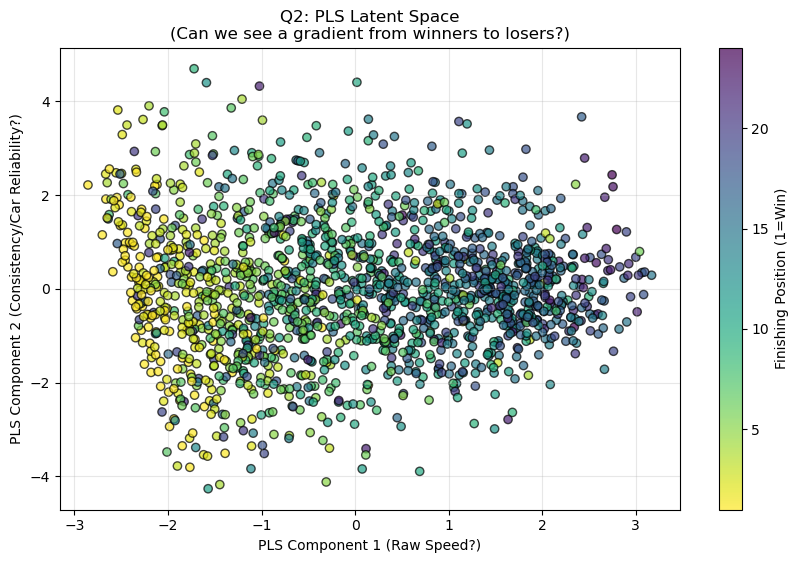

In [78]:
# Visualizing the PLS Latent Space
X_pls_transform = pls_final.transform(X_test_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pls_transform[:, 0], X_pls_transform[:, 1], 
            c=y2_test, cmap='viridis_r', alpha=0.7, edgecolors='k')
plt.colorbar(scatter, label='Finishing Position (1=Win)')
plt.xlabel('PLS Component 1 (Raw Speed?)')
plt.ylabel('PLS Component 2 (Consistency/Car Reliability?)')
plt.title('Q2: PLS Latent Space\n(Can we see a gradient from winners to losers?)')
plt.grid(True, alpha=0.3)
plt.show()

**Plotting**

C:\Users\couga\AppData\Local\Temp\ipykernel_37148\997484556.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lasso_importances, x='Lasso_Coef_Abs', y='Feature', ax=ax[0], palette='viridis')
C:\Users\couga\AppData\Local\Temp\ipykernel_37148\997484556.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importances, x='Importance', y='Feature', ax=ax[1], palette='magma')


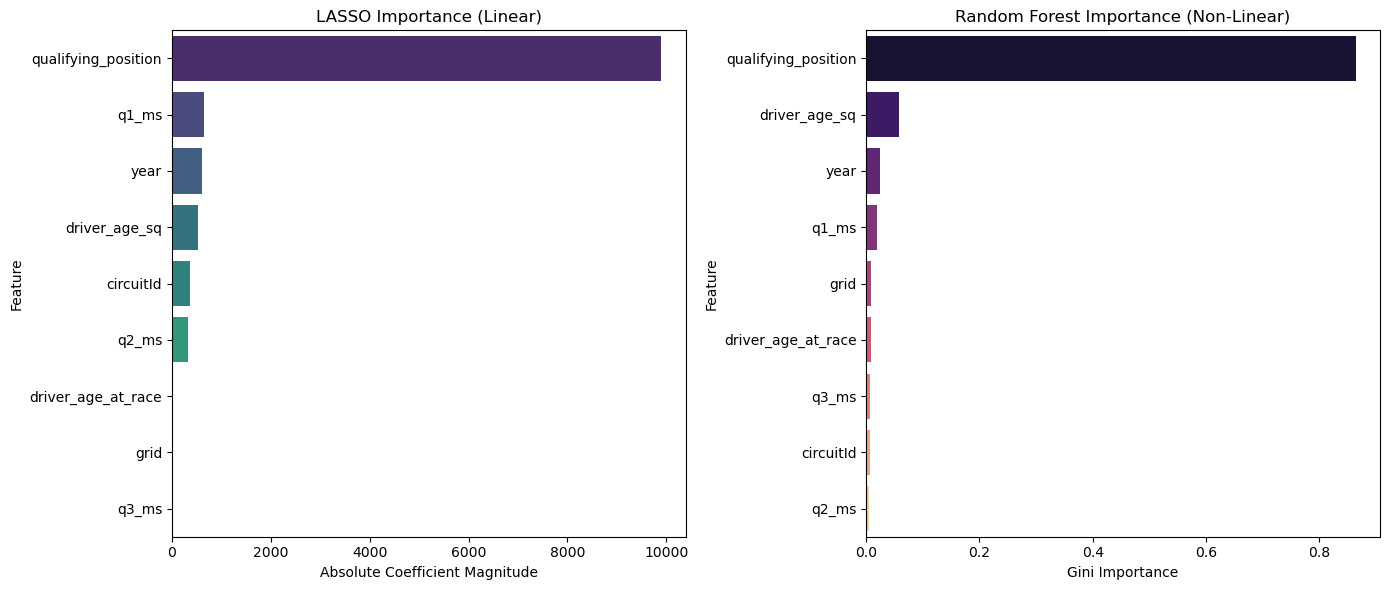

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(data=lasso_importances, x='Lasso_Coef_Abs', y='Feature', ax=ax[0], palette='viridis')
ax[0].set_title('LASSO Importance (Linear)')
ax[0].set_xlabel('Absolute Coefficient Magnitude')

sns.barplot(data=rf_importances, x='Importance', y='Feature', ax=ax[1], palette='magma')
ax[1].set_title('Random Forest Importance (Non-Linear)')
ax[1].set_xlabel('Gini Importance')
plt.tight_layout()
plt.show()

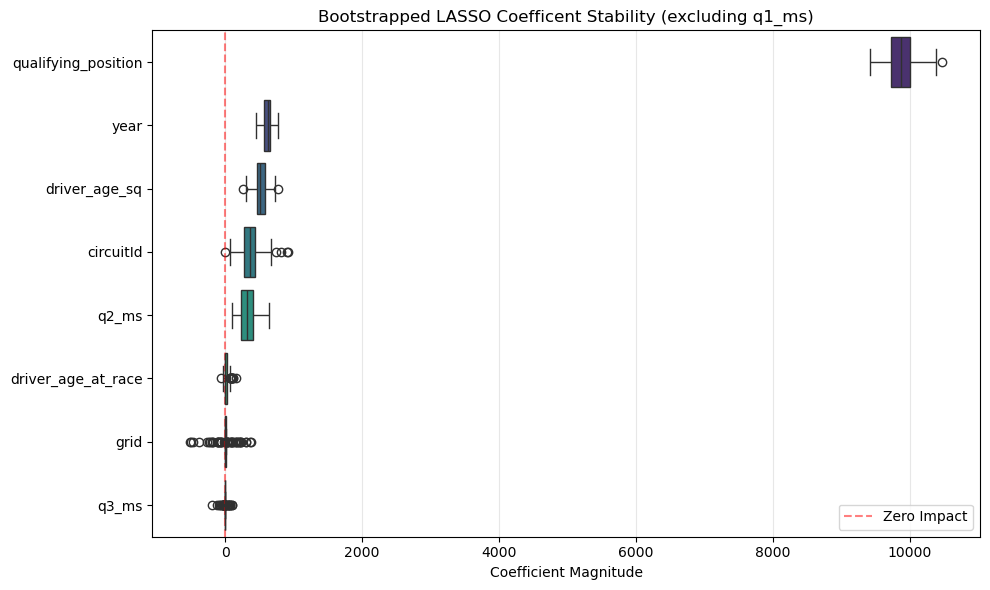

In [80]:
# Plotting Coefficient Stability
plt.figure(figsize=(10, 6))

# Data Filtration
bs_df = bootstrap_df.drop(columns=['q1_ms']) # Remove 'q1_ms' otherwise plot gets cluttered
relevant_cols = bs_df.columns[bs_df.abs().mean() > 1]
plot_data = bs_df[relevant_cols]

# Sorted by mean coefficient magnitude
sorted_features = plot_data.mean().sort_values(ascending=False).index

sns.boxplot(data=bs_df[sorted_features], orient='h', palette='viridis')
plt.title("Bootstrapped LASSO Coefficent Stability (excluding q1_ms)")
plt.xlabel("Coefficient Magnitude")
plt.ylabel("")
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label="Zero Impact") # Subtle zero line
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

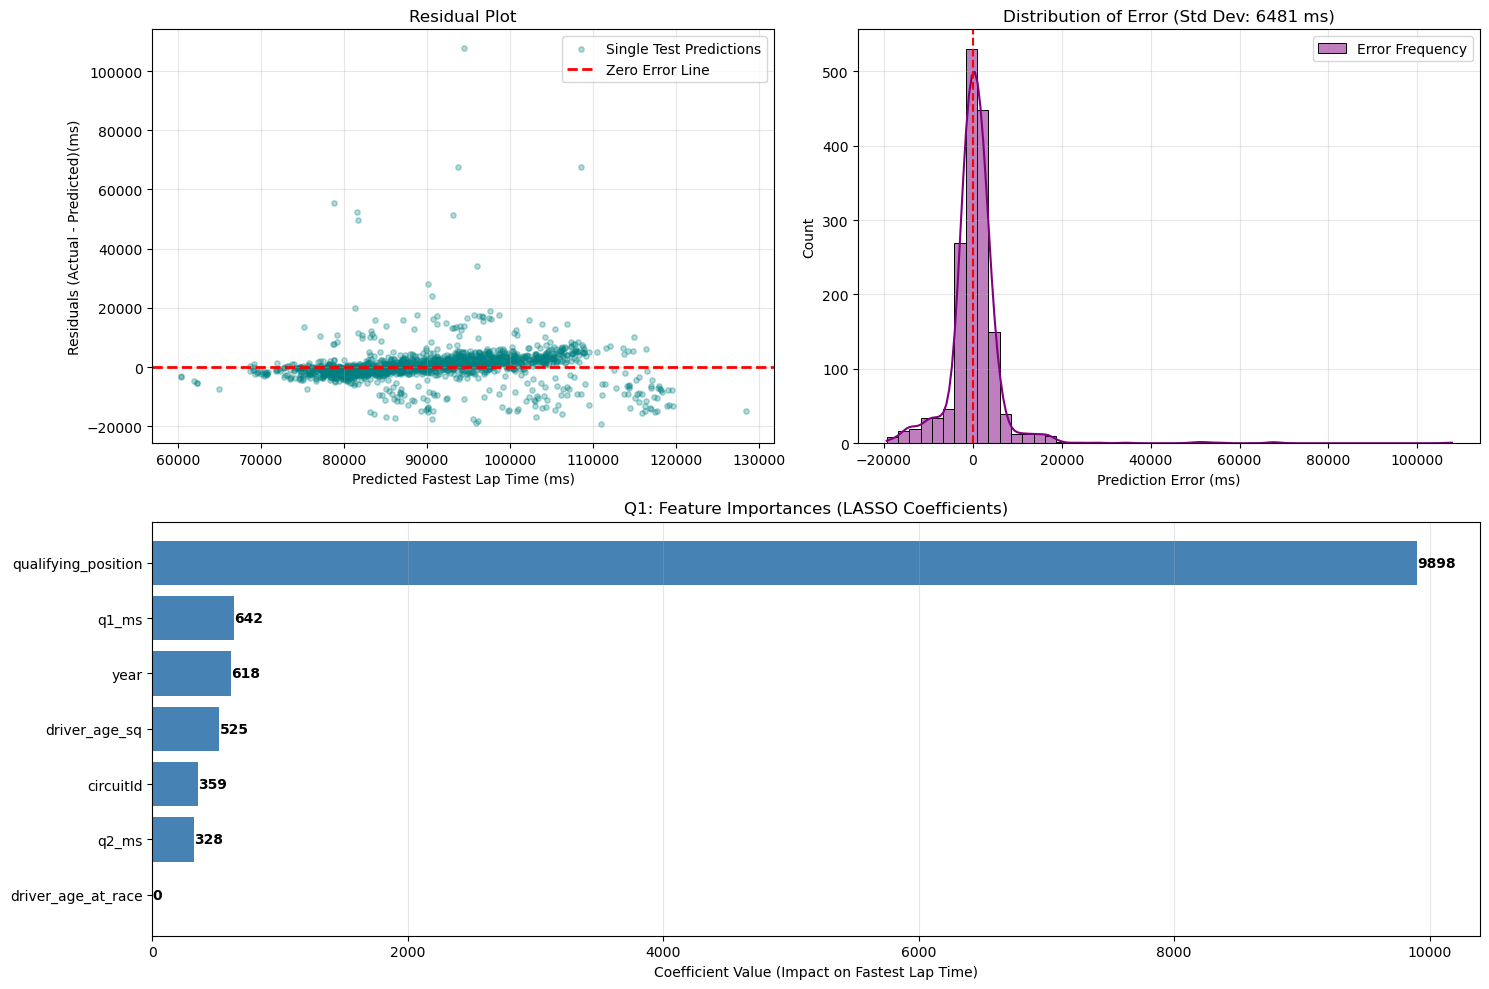

In [81]:
y1_pred = lasso_model.predict(X_test_scaled)
residuals = y1_test - y1_pred

plt.figure(figsize=(15, 10))

# Setting up subplots
# Residual Plot
plt.subplot(2, 2, 1)
plt.scatter(y1_pred, residuals, alpha=0.3, color='teal', s=15, label='Single Test Predictions')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
plt.xlabel('Predicted Fastest Lap Time (ms)')
plt.ylabel('Residuals (Actual - Predicted)(ms)')
plt.title('Residual Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=50, label='Error Frequency')
plt.xlabel('Prediction Error (ms)')
plt.title(f'Distribution of Error (Std Dev: {np.std(residuals):.0f} ms)')
plt.axvline(x=0, color='red', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)

# LASSO Coefficients (Feature Importance)
nonzero_coefs = coefs[coefs['AbsCoef'] > 0].sort_values(by='AbsCoef', ascending=True)
plt.subplot(2, 1, 2)
bars = plt.barh(nonzero_coefs['Feature'], nonzero_coefs['Coef'], color='steelblue', label='LASSO Coefficient')
for bar in bars:
    width = bar.get_width()
    plt.text(
        width, 
        bar.get_y() + bar.get_height() / 2,
        f'{int(width)}',
        va='center',
        ha='left',
        fontsize=10,
        color='black',
        fontweight='bold'
    )
plt.title("Q1: Feature Importances (LASSO Coefficients)")
plt.xlabel('Coefficient Value (Impact on Fastest Lap Time)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

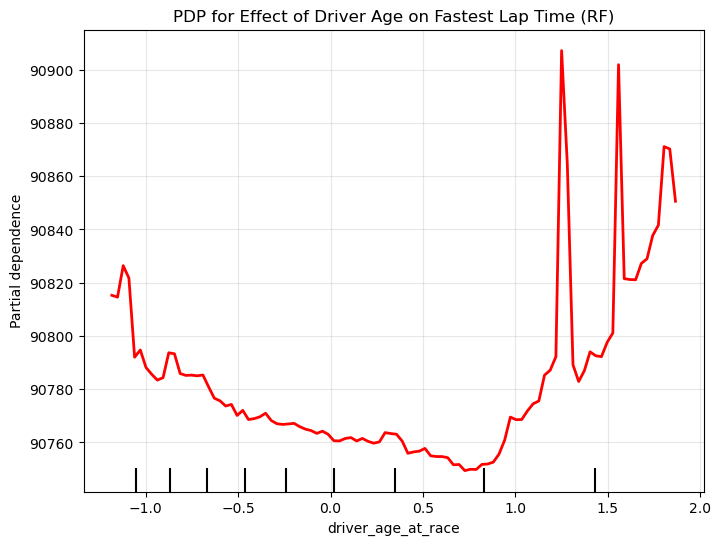

In [82]:
# Partial Dependence Plot to show non-linearity of 'driver_age_at_race'
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(
    rf_reg,
    X_train_scaled,
    features=[X_cols.index('driver_age_at_race')],
    feature_names=X_cols,
    kind='average',
    ax=ax,
    line_kw={"color": "red", "linewidth": 2}
)
plt.title("PDP for Effect of Driver Age on Fastest Lap Time (RF)")
plt.grid(True, alpha=0.3)
plt.show()

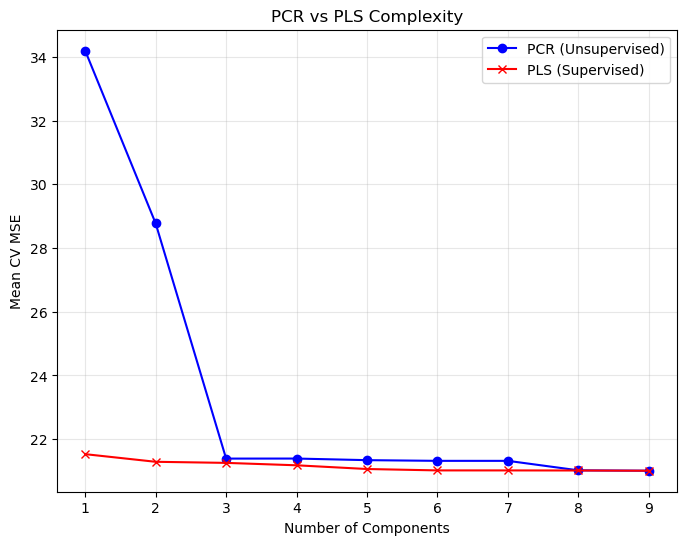

In [83]:
plt.figure(figsize=(8,6))
plt.plot(n_comp, pcr_mean_mse, marker='o', label='PCR (Unsupervised)', linestyle='-', color='blue')
plt.plot(n_comp, pls_mean_mse, marker='x', label='PLS (Supervised)', linestyle='-', color='red')

plt.xlabel('Number of Components')
plt.ylabel('Mean CV MSE')
plt.title('PCR vs PLS Complexity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

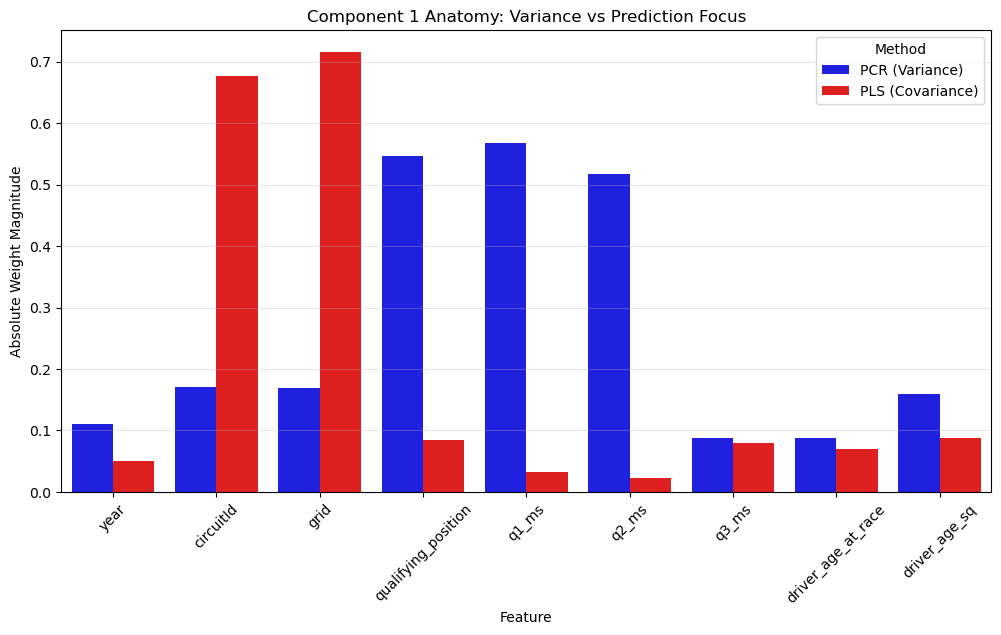

In [84]:
# Component Weights Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=comp_weights, x='Feature', y='Weight', hue='Method', palette=['blue', 'red'])
plt.title("Component 1 Anatomy: Variance vs Prediction Focus")
plt.xticks(rotation=45)
plt.ylabel("Absolute Weight Magnitude")
plt.grid(axis='y', alpha=0.3)
plt.show()

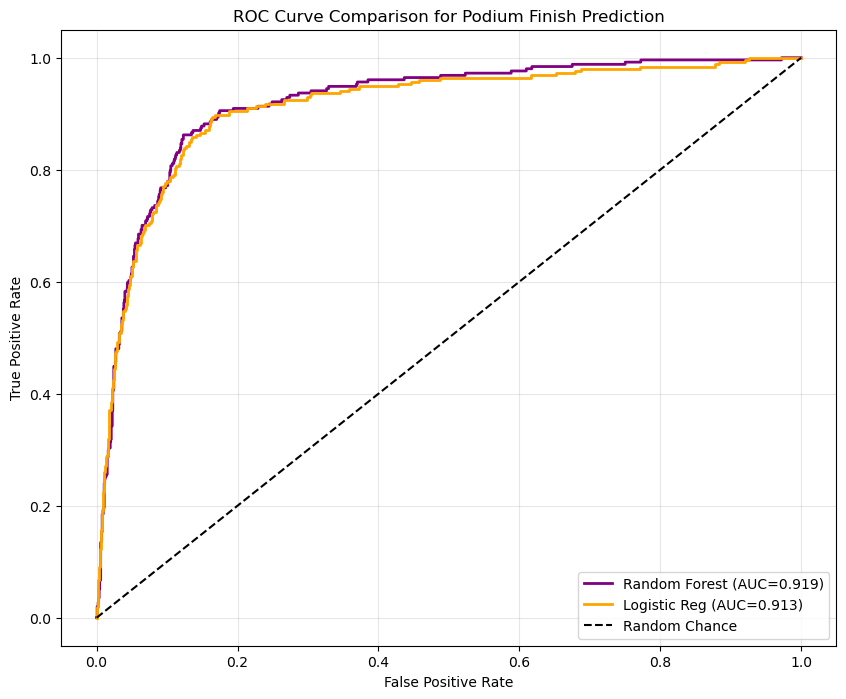

In [85]:
# ROC Curve for Podium Prediction
y_prob_lr = lr_clf.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf_clf.predict_proba(X_test_scaled)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y3_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)
fpr_rf, tpr_rf, _ = roc_curve(y3_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', color='purple', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={auc_lr:.3f})', color='orange', linewidth=2)
plt.plot([0, 1], [0, 1], color='k', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Podium Finish Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Confusion Matrix at Optimal Threshold

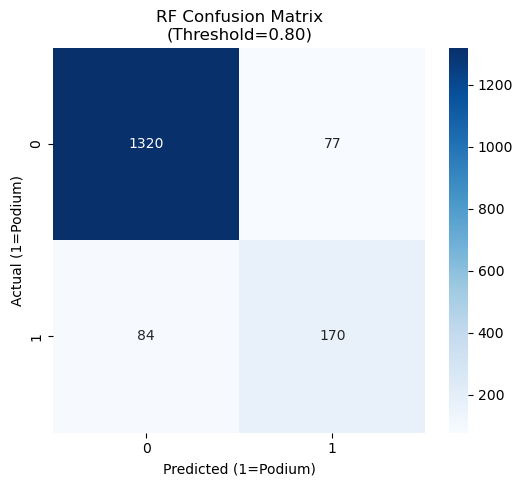

In [86]:
# RF Confusion Matrix at Optimal Threshold
y_pred_optimal = (y_prob_rf >= best_thresh).astype(int)
cm = confusion_matrix(y3_test, y_pred_optimal)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"RF Confusion Matrix\n(Threshold={best_thresh:.2f})")
plt.xlabel('Predicted (1=Podium)')
plt.ylabel('Actual (1=Podium)')
plt.show()

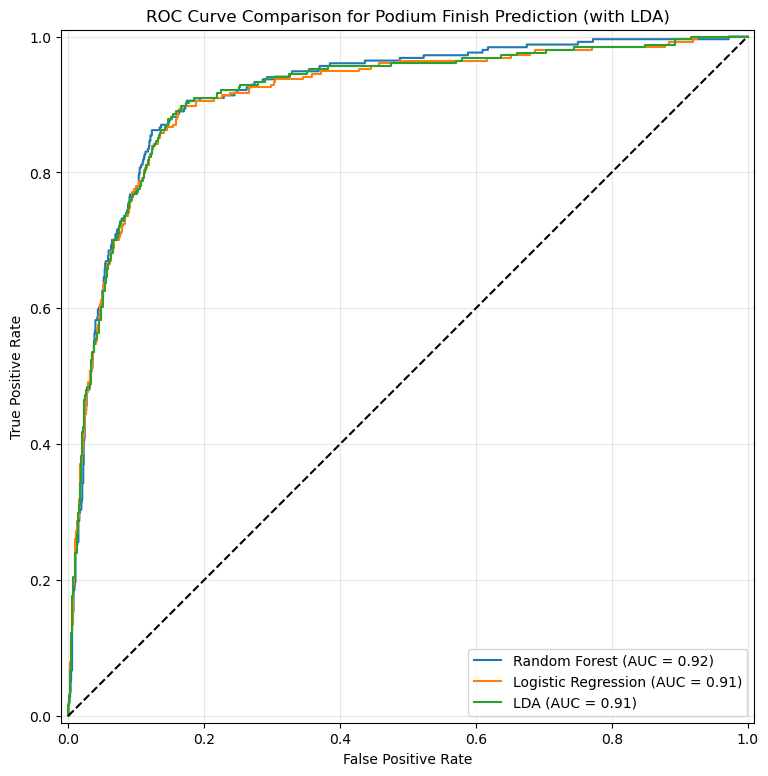

In [87]:
# ROC Curve with LDA included
plt.figure(figsize=(12,9))
RocCurveDisplay.from_estimator(best_rf_clf, X_test_scaled, y3_test, ax=plt.gca(), name='Random Forest')
RocCurveDisplay.from_estimator(lr_clf, X_test_scaled, y3_test, ax=plt.gca(), name='Logistic Regression')
RocCurveDisplay.from_estimator(lda, X_test_scaled, y3_test, ax=plt.gca(), name='LDA')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Podium Finish Prediction (with LDA)')
plt.grid(True, alpha=0.3)
plt.show()

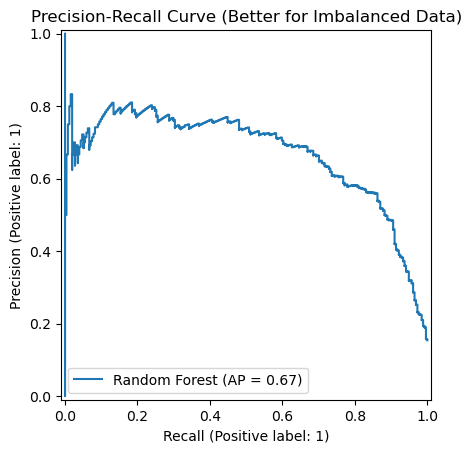

In [88]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(best_rf_clf, X_test_scaled, y3_test, name="Random Forest")
plt.title("Precision-Recall Curve (Better for Imbalanced Data)")
plt.show()